**Описание задачи:**

Судя по данным, лежащие в файле *Ad_revenue.xlsx*, предположите как нарастает ревеню в первый месяц жизни у пользователей игры.

Во сколько раз увеличится ревеню 30-го дня относительно нулевого, первого и третьего дней.

### Импорт библиотек

In [603]:
import pandas as pd
import seaborn as sns
import ydata_profiling
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
import datetime as dt

In [604]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

### EDA

In [605]:
file_path = r'C:\Users\user\Downloads\Ad_revenue.xlsx'

Создадим датасеты

In [606]:
df_ad_revenue = pd.read_excel(file_path, sheet_name = 'ad revenue')

In [607]:
df_installs_data = pd.read_excel(file_path, sheet_name = 'installs data')

Взглянем на датасеты

In [608]:
df_ad_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78723 entries, 0 to 78722
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   install_date   78723 non-null  datetime64[ns]
 1   event_date     78723 non-null  datetime64[ns]
 2   event_revenue  77812 non-null  float64       
 3   platform       78723 non-null  object        
 4   user_id        78723 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 3.0+ MB


In [609]:
df_installs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   install_date  579 non-null    datetime64[ns]
 1   installs      579 non-null    int64         
 2   platform      579 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 13.7+ KB


In [610]:
df_ad_revenue.head()

,install_date,event_date,event_revenue,platform,user_id
0,2023-09-21,2023-09-21,0.316470,android,1695339148585-8391306266630234966
1,2023-09-21,2023-09-21,0.063103,android,1695280270975-5411644856462553821
2,2023-09-21,2023-09-21,0.316470,android,1695317488398-8939481192662600393
3,2023-09-21,2023-09-21,0.054710,android,1695317488398-8939481192662600393
4,2023-09-21,2023-09-21,0.024880,android,1695280270975-5411644856462553821


In [611]:
df_installs_data.head()

,install_date,installs,platform
0,2023-09-21,1,android
1,2023-09-21,0,android
2,2023-09-21,47,android
3,2023-09-21,0,android
4,2023-09-21,0,android


In [612]:
#ydata_profiling.ProfileReport(df_ad_revenue, explorative=True).to_widgets()

In [613]:
#ydata_profiling.ProfileReport(df_installs_data, explorative=True).to_widgets()

Сгруппируем установки по дате

In [614]:
df_installs_dates = df_installs_data.groupby('install_date')['installs'].sum().reset_index()
df_installs_dates

,install_date,installs
0,2023-09-21,718
1,2023-09-22,671
2,2023-09-23,693
3,2023-09-24,891
4,2023-09-25,1349
5,2023-09-26,1612
6,2023-09-27,1649
7,2023-09-28,1594


Сгруппируем прибыль по дате установки и посчитаем кумулятивную прибыль

In [615]:
install_date_revenue = df_ad_revenue.groupby('install_date')['event_revenue'].sum().reset_index()
install_date_revenue['cumulative_revenue'] = install_date_revenue['event_revenue'].cumsum()

In [616]:
install_date_revenue

,install_date,event_revenue,cumulative_revenue
0,2023-09-21,565.577608,565.577608
1,2023-09-22,635.464425,1201.042033
2,2023-09-23,742.279232,1943.321265
3,2023-09-24,1012.421014,2955.742279
4,2023-09-25,1458.796868,4414.539147
5,2023-09-26,1577.301640,5991.840787
6,2023-09-27,1496.667418,7488.508205
7,2023-09-28,1200.336723,8688.844928


За данный промежуток времени было заработано 8688

Построим график роста прибыли

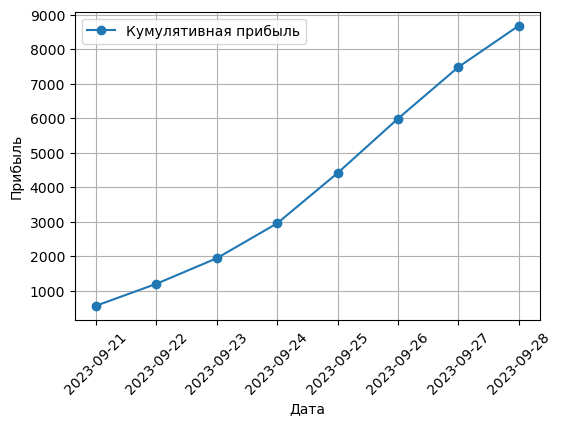

In [617]:
plt.figure(figsize=(6, 4))

plt.plot(install_date_revenue['install_date'],
         install_date_revenue['cumulative_revenue'],
         label='Кумулятивная прибыль',
         marker='o')

plt.xlabel('Дата')
plt.ylabel('Прибыль')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

Сгруппируем данные по дате установки и по дате совершения события, чтобы знать, сколько прибыли приносит когорта в определенный день

In [618]:
cohort_revenue = df_ad_revenue.groupby(['install_date', 'event_date']).agg({'event_revenue': 'sum'}).reset_index()
cohort_revenue['cumulative_revenue'] = grouped_revenue.groupby('install_date')['event_revenue'].cumsum()

cohort_revenue['event_date'] = pd.to_datetime(grouped_revenue['event_date']).dt.date
cohort_revenue['install_date'] = pd.to_datetime(grouped_revenue['install_date']).dt.date

Взглянем на первые строки

In [619]:
cohort_revenue.head()

,install_date,event_date,event_revenue,cumulative_revenue
0,2023-09-21,2023-09-21,251.841119,251.841119
1,2023-09-21,2023-09-22,90.565458,342.406577
2,2023-09-21,2023-09-23,56.141451,398.548028
3,2023-09-21,2023-09-24,41.126944,439.674972
4,2023-09-21,2023-09-25,33.507381,473.182353


Построим графики по кумулятивной прибыли по каждой дневной когорте

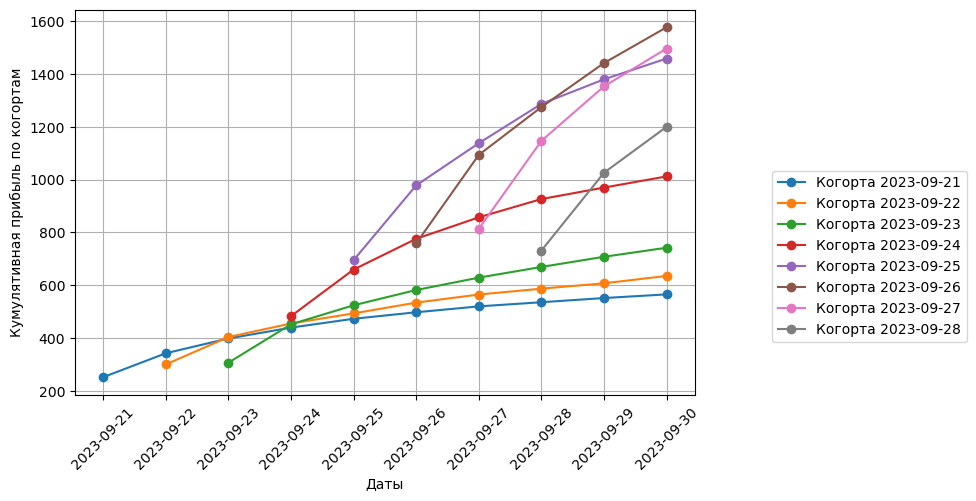

In [620]:
unique_install_dates = cohort_revenue['install_date'].unique()

plt.figure(figsize=(8, 5))

for date in unique_install_dates:
    cohort_data = cohort_revenue[cohort_revenue['install_date'] == date]
    plt.plot(cohort_data['event_date'], cohort_data['cumulative_revenue'], marker='o', label=f'Когорта {date}')

plt.xlabel('Даты')
plt.ylabel('Кумулятивная прибыль по когортам')
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.6))
plt.grid(True)

plt.show()

График показывает, что пиковые значения дохода приходятся на нулевой день и затем происходит снижение прибыли: показатели доходности бесконечно стремятся к значениям, близким к нулю.

### Анализ дневных когорт

Чтобы примерно узнать, к каким конкретно значениям падает доходность, узнаем процентное изменение доходности

In [621]:
cohort_revenue_copy = cohort_revenue.copy()

In [622]:
cohort_revenue['event_revenue'] = cohort_revenue['event_revenue'].fillna(0)
cohort_revenue['cumulative_revenue'] = cohort_revenue['cumulative_revenue'].fillna(0)

In [623]:
cohort_revenue['revenue_change_percentage'] = cohort_revenue.groupby('install_date')['cumulative_revenue'].pct_change() * 100
cohort_revenue['revenue_change_percentage'] = cohort_revenue['revenue_change_percentage'].fillna(0)

In [624]:
cohort_revenue['date_difference'] = (cohort_revenue['event_date'] - cohort_revenue['install_date']).dt.days

Теперь определим среднее изменение доходности когорты

Построим матрицы

In [625]:
cohort_revenue_total = cohort_revenue.pivot_table(
    index='date_difference',
    values='cumulative_revenue',
    columns='install_date').T

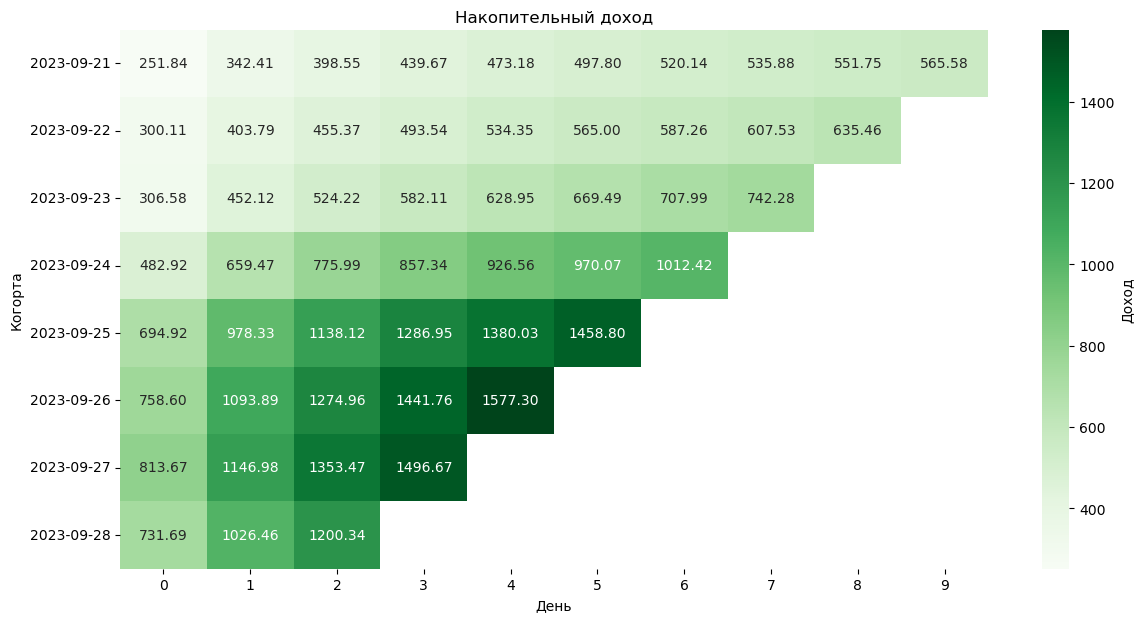

In [626]:
plt.figure(figsize=(14, 7)) 
sns.heatmap(cohort_revenue_total,
            cmap='Greens',
            annot=True,
            fmt=".2f",
            cbar_kws={'label': 'Доход'})

plt.title("Накопительный доход")
plt.xlabel("День")
plt.ylabel("Когорта")

plt.show()

In [627]:
cohort_revenue_perc = cohort_revenue.pivot_table(
    index='date_difference',
    values='revenue_change_percentage',
    columns='install_date').T

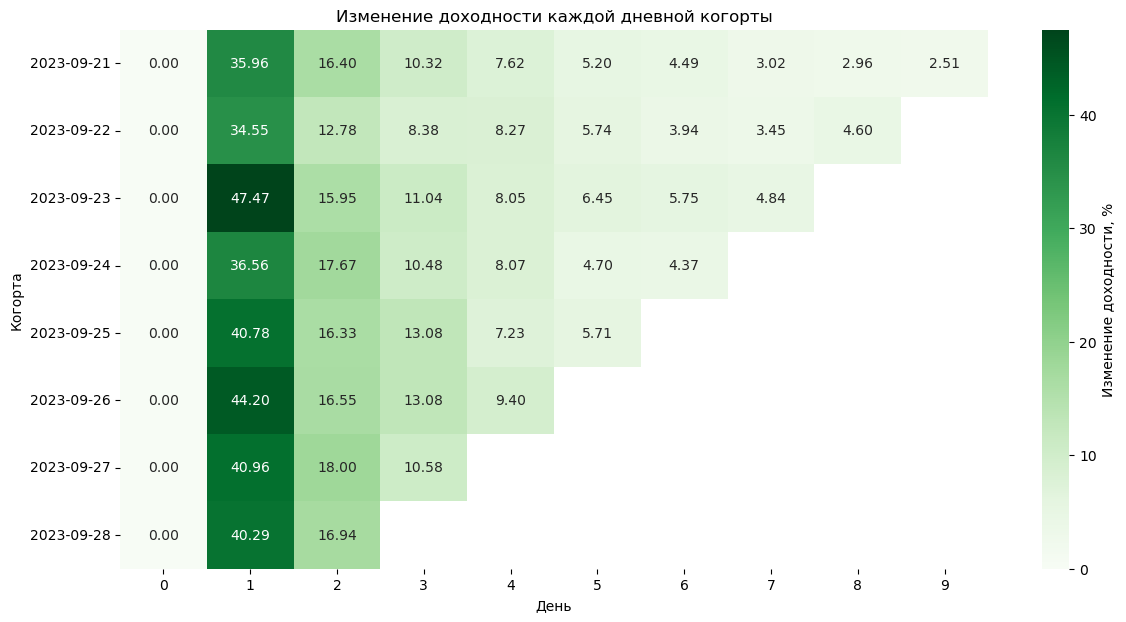

In [628]:
plt.figure(figsize=(14, 7)) 
sns.heatmap(cohort_revenue_pivot,
            cmap='Greens',
            annot=True,
            fmt=".2f",
            cbar_kws={'label': 'Изменение доходности, %'})

plt.title("Изменение доходности каждой дневной когорты")
plt.xlabel("День")
plt.ylabel("Когорта")

plt.show()

Теперь можно вывести средние значения роста ревеню в процентах

In [629]:
average_revenue_change = round(
    cohort_revenue.pivot_table(
        index='date_difference',
        values='revenue_change_percentage',
        columns='install_date').mean(axis=1), 2).reset_index()

In [630]:
average_revenue_change

,date_difference,0
0,0,0.00
1,1,40.10
2,2,16.33
3,3,11.00
4,4,8.11
5,5,5.56
6,6,4.64
7,7,3.77
8,8,3.78
9,9,2.51


### Прогноз ревеню

#### Ревеню D0, D1, D3

Спрогнозируем рост ревеню до 9-го дня, экстраполируя изменение ежедневного роста ревеню в процентном соотношении на когорты 2023-09-22+

In [631]:
cohort_revenue_total.columns = [f'{i}' for i in range(10)]
cohort_revenue_total.index.name = 'install_date'

In [632]:
def extrapolate_revenue(cohort_data, avg_change):
    max_days = len(avg_change)
    for cohort in cohort_data.index:
        for day in range(max_days):
            day_col = f"{day}"
            if day_col not in cohort_data.columns or pd.isna(cohort_data.loc[cohort, day_col]):
                prev_day_col = f"{day-1}"
                if prev_day_col in cohort_data.columns and not pd.isna(cohort_data.loc[cohort, prev_day_col]):
                    last_value = cohort_data.loc[cohort, prev_day_col]
                    change = avg_change.loc[avg_change['date_difference'] == day, 0].values[0]
                    new_value = last_value * (1 + change / 100)
                    cohort_data.loc[cohort, day_col] = new_value
    return cohort_data

In [633]:
cohort_revenue_predict = extrapolate_revenue(cohort_revenue_total, average_revenue_change)

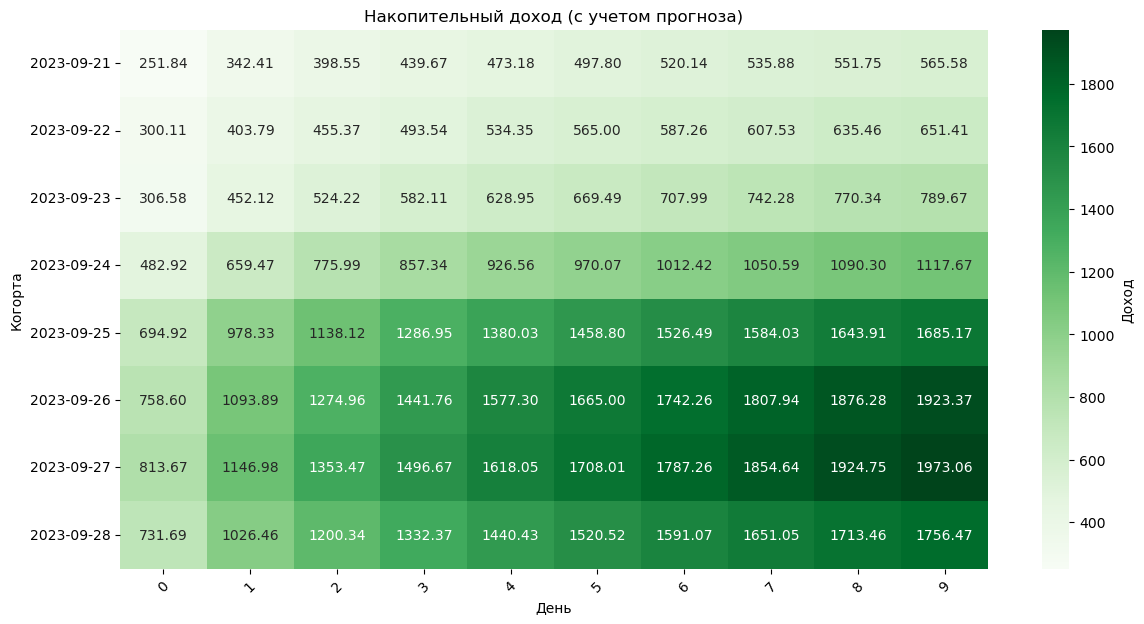

In [634]:
plt.figure(figsize=(14, 7)) 
sns.heatmap(cohort_revenue_predict,
            cmap='Greens',
            annot=True,
            fmt=".2f",
            cbar_kws={'label': 'Доход'})

plt.xticks(rotation=45)

plt.title("Накопительный доход (с учетом прогноза)")
plt.xlabel("День")
plt.ylabel("Когорта")

plt.show()

Просуммируем доходность по отдельным дням

In [635]:
total = cohort_revenue_predict.sum(axis=0)

In [636]:
print(f'Ревеню нулевого дня - {total[0]} ')
print(f'Ревеню первого дня - {total[1]} ')
print(f'Ревеню третьего дня - {total[3]} ')

Ревеню нулевого дня - 4340.317628000001 
Ревеню первого дня - 6103.430407 
Ревеню третьего дня - 7930.41926453 


#### Ревеню D30

Чтобы спрогнозировать как нарастает ревеню когорты в первый месяц жизни, используем модель прогнозирования **ARIMA**

In [637]:
model = ARIMA(total, order=(1, 1, 0))
model_fit = model.fit()

days = 21  # количество дней для прогноза
predict_total = model_fit.forecast(steps=forecast_days)

Теперь можем визуализировать прогнозируемую доходность когорты

In [638]:
# Преобразуем индексы в числовой формат
total.index = total.index.astype(int)
predict_total.index = predict_total.index.astype(int)

In [639]:
combined = pd.concat([total, predict_total])

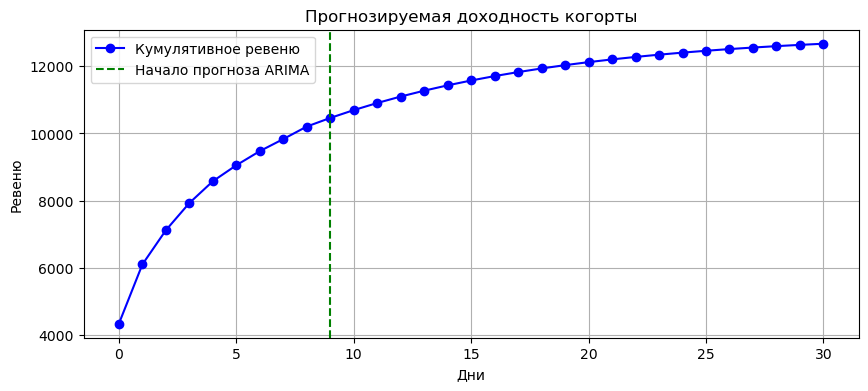

In [640]:
# Построение графика
plt.figure(figsize=(10, 4))
plt.plot(combined.index, combined, marker='o', label='Кумулятивное ревеню', color='blue')

plt.axvline(x=total.index[-1], color='green', linestyle='--', label='Начало прогноза ARIMA')

plt.xlabel("Дни")
plt.ylabel("Ревеню")
plt.title("Прогнозируемая доходность когорты")
plt.legend()
plt.grid(True)

plt.show()

In [641]:
print(f'Ревеню 30-го дня {predict_total.iloc[-1]}')

Ревеню 30-го дня 12670.465963867131


### Вывод:

Посчитаем, во сколько раз увеличился ревеню 30-го дня относительно 0-го, 1-го и 3-го дней

In [642]:
print(f'Revenue D30 выросло относительно D0 в {round(combined.iloc[-1] / combined.iloc[0], 2)} раза')
print(f'Revenue D30 выросло относительно D1 в {round(combined.iloc[-1] / combined.iloc[1], 2)} раза')
print(f'Revenue D30 выросло относительно D3 в {round(combined.iloc[-1] / combined.iloc[3], 2)} раза')

Revenue D30 выросло относительно D0 в 2.92 раза
Revenue D30 выросло относительно D1 в 2.08 раза
Revenue D30 выросло относительно D3 в 1.6 раза
